# Todo
1. Separate lensing p generation from primordial maps
1. Implement quadratic estimator
1. Write standard functions for l**2/(2*np.pi), etc
1. Label plots
1. Improve plot2Maps by adding labels and colorbar/range options

In [1]:
from cmb_simulation import *

In [2]:
# getCambSpectra
powers = getCambSpectra()
print(powers.keys())
print(powers['unlensed_scalar'].shape)

dict_keys(['total', 'unlensed_scalar', 'unlensed_total', 'lensed_scalar', 'tensor', 'lens_potential'])
(7051, 4)


# Basics

In [22]:
# get_ls
d = 0.1
N = 9
lx, ly = get_ls(d, N)
print(lx * d*N/2/np.pi)
print(ly * d*N/2/np.pi)
# validate:
# kx goes horizontally (second coord)
# ky goes vertically (first coord)

[[0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]]
[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.]
 [-4. -4. -4. -4. -4.]
 [-3. -3. -3. -3. -3.]
 [-2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1.]]


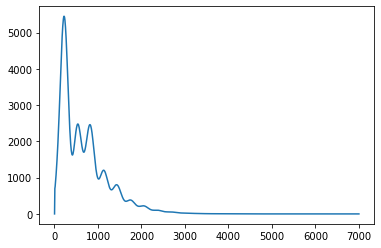

In [47]:
# Spectrum.plot
cmb = CMBSpectra(powers)
ls = np.linspace(1, 7000, 1000)
cmb.TT.plot(ls, lambda l: l**2/(2*np.pi))

# Generating maps by sampling

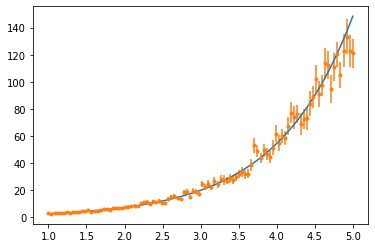

In [56]:
spec = Spectrum(np.exp)
ls = np.linspace(1, 5, 100)
samples = np.array([spec.sample(ls) for _ in range(100)])
means = np.mean((samples*samples.conj()).real, axis=0)
stds = np.std((samples*samples.conj()).real, axis=0)/np.sqrt(100)

spec.plot(ls)
plt.errorbar(ls, means, stds, fmt='.')
plt.show()
# validate: line goes through points, error bars make sense

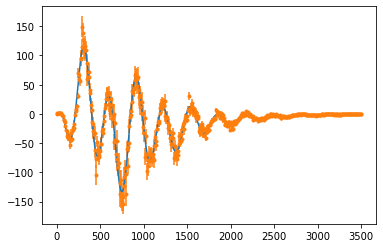

In [57]:
# choleskyUnlensed, sampleCov
cmb = CMBSpectra(powers)
ls = np.linspace(0, 3500, 500)
chol = cmb.choleskyUnlensed(ls)
samples = np.array([sampleCov(chol) for _ in range(100)])
means_TT = np.mean((samples[:,:,0]*samples[:,:,0].conj()).real, axis=0)
stds_TT = np.std((samples[:,:,0]*samples[:,:,0].conj()).real, axis=0)/np.sqrt(100)
means_EE = np.mean((samples[:,:,1]*samples[:,:,1].conj()).real, axis=0)
stds_EE = np.std((samples[:,:,1]*samples[:,:,1].conj()).real, axis=0)/np.sqrt(100)
means_TE = np.mean((samples[:,:,0]*samples[:,:,1].conj()).real, axis=0)
stds_TE = np.std((samples[:,:,0]*samples[:,:,1].conj()).real, axis=0)/np.sqrt(100)

# cmb.TT.plot(ls, lambda l: l**2/(2*np.pi))
# plt.errorbar(ls, means_TT*ls**2/(2*np.pi), stds_TT*ls**2/(2*np.pi), fmt='.')
# cmb.EE.plot(ls, lambda l: l**2/(2*np.pi))
# plt.errorbar(ls, means_EE*ls**2/(2*np.pi), stds_EE*ls**2/(2*np.pi), fmt='.')
cmb.TE.plot(ls, lambda l: l**2/(2*np.pi))
plt.errorbar(ls, means_TE*ls**2/(2*np.pi), stds_TE*ls**2/(2*np.pi), fmt='.')
plt.show()
# validate: curves passes through points, error bars look reasonable

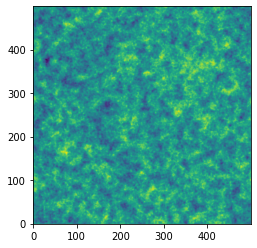

In [3]:
# generatePrimordialMaps, CMBMap.plot
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb, p = cmb.generatePrimordialMaps(d, N)

teb.T.plot()
# teb.E.plot()
# p.plot()

In [84]:
# temperature fluctuation
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb, p = cmb.generatePrimordialMaps(d, N)

np.std(teb.T.r)
# validate: stdev ~ 100 muK

102.97210537774505

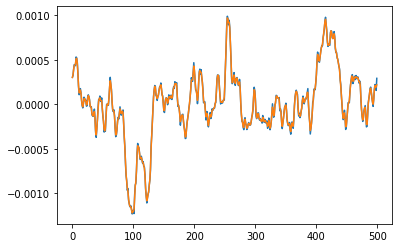

2.1643849558806374

In [10]:
# grad, RMS lensing deflection
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb, p = cmb.generatePrimordialMaps(d, N)

px, py = grad(p)
py_np, px_np = np.gradient(p.r, d)

plt.plot(px.r[100])
plt.plot(px_np[100])
plt.show()

np.sqrt(np.mean(px.r**2 + py.r**2)) / np.pi*180*60
# validate: curves overlap
# ~2 arcmin

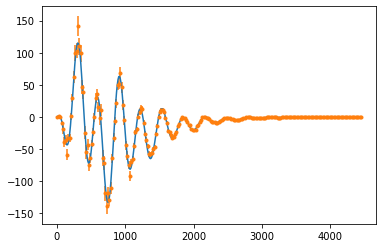

In [73]:
# generatePrimordialMaps, binnedCorrelation
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb, p = cmb.generatePrimordialMaps(d, N)

cmb.TE.plot(np.linspace(1, 4200, 400), lambda l: l**2/(2*np.pi))
avg = binnedCorrelation(teb.T, teb.E)
avg.plot(lambda l: l**2/(2*np.pi), fmt='.')
# validate: curve passes through points, error bars are reasonable

In [13]:
# getTQU
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb, p = cmb.generatePrimordialMaps(d, N)
tqu = teb.getTQU()

lx, ly = get_ls(d, N)
phi_l = np.arctan2(ly, lx)
P1 = teb.E.f + 1j*teb.B.f
P2 = np.exp(-2j*phi_l) * (tqu.Q.f + 1j*tqu.U.f)
np.max(((P1-P2)*(P1-P2).conj()).real)
# validate: difference is tiny

5.624828165360588e-23

In [15]:
# getTEB
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb, p = cmb.generatePrimordialMaps(d, N)
tqu = teb.getTQU()
teb2 = tqu.getTEB()

np.max(teb.E.r-teb2.E.r)-np.min(teb.E.r-teb2.E.r)
# validate: difference is tiny

2.3092638912203256e-14

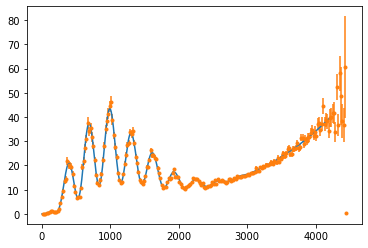

In [31]:
# addNoise
d = 0.001
N = 500
cmb = CMBSpectra(powers)
teb, p = cmb.generatePrimordialMaps(d, N)
simons = Detector(*simons_params)
teb_obs = simons.addNoise(teb)

(cmb.EE + simons.EEn).plot(np.linspace(1, 4200, 500), lambda l: l**2/(2*np.pi))
teb_obs.E.binSpectrum().plot(lambda l: l**2/(2*np.pi), fmt='.')
# validate: curves match and error bars are reasonable

# Lensing and convolution

In [3]:
d = 0.0004
N = 1000
cmb = CMBSpectra(powers)
teb, p = cmb.generatePrimordialMaps(d, N)

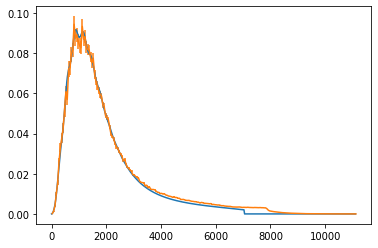

In [4]:
# Lensing by cubic interpolation
teb_len1 = lensTEB(teb, p, fun=lensInterp)

ls = np.linspace(1, np.max(teb_len1.ml), 500)
cmb.BB_len.plot(ls, lambda l: l**2/(2*np.pi))
teb_len1.B.binSpectrum(delta=50).plot(lambda l: l**2/(2*np.pi))
# 2.5s

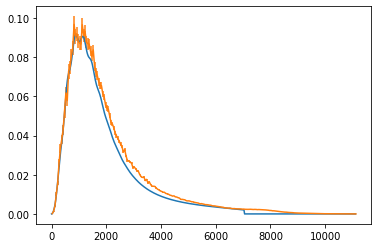

In [5]:
# Lensing by simple Taylor expansion
teb_len2 = lensTEB(teb, p, fun=lensTaylor)

ls = np.linspace(1, np.max(teb_len1.ml), 500)
cmb.BB_len.plot(ls, lambda l: l**2/(2*np.pi))
teb_len2.B.binSpectrum(delta=50).plot(lambda l: l**2/(2*np.pi))
# 1.9s, worse convergence than interp

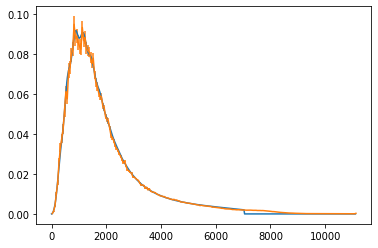

In [6]:
# Lensing by simple Taylor expansion
teb_len3 = lensTEB(teb, p, fun=lensTaylorNearest)

ls = np.linspace(1, np.max(teb_len1.ml), 500)
cmb.BB_len.plot(ls, lambda l: l**2/(2*np.pi))
teb_len3.B.binSpectrum(delta=50).plot(lambda l: l**2/(2*np.pi))
# 10.4s, better convergence than interp

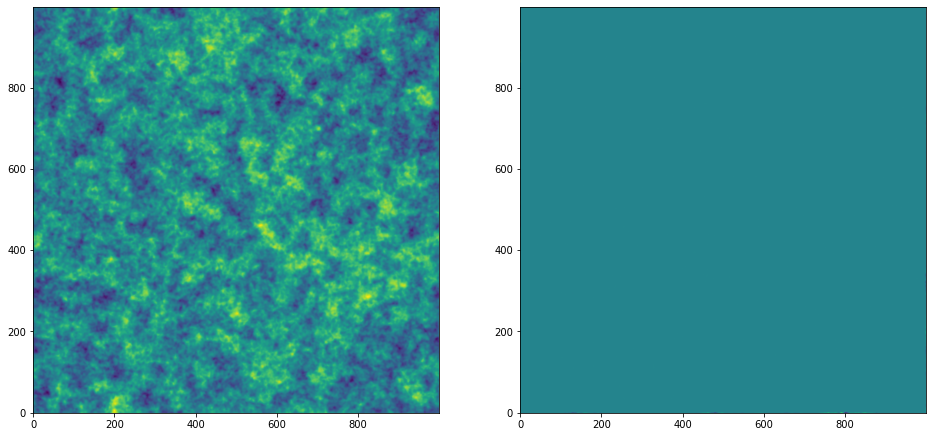

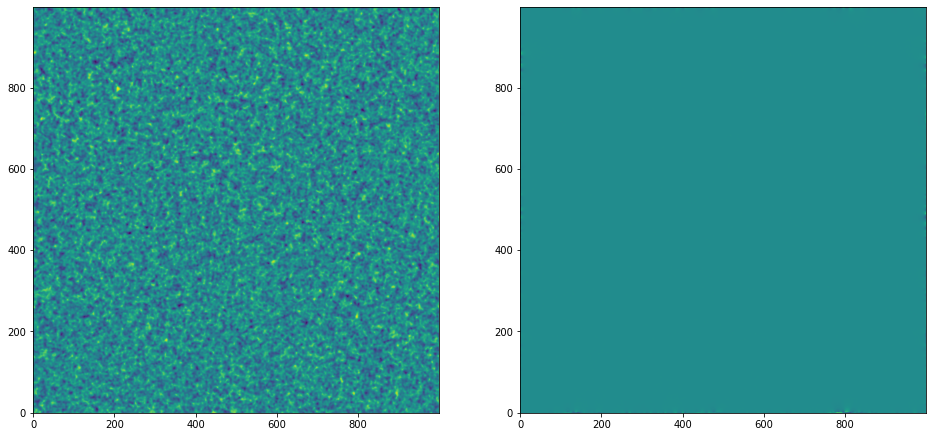

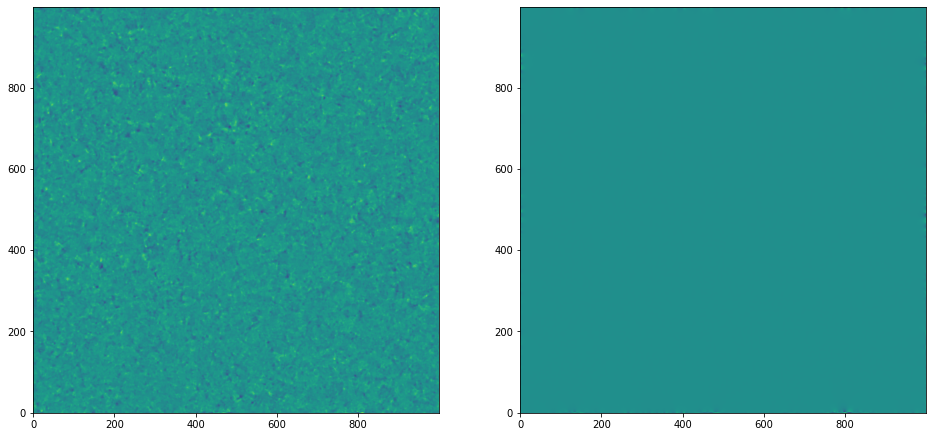

In [12]:
# Interp and Taylor(Nearest) are consistent with each other
plot2Maps(teb_len1.T.r, teb_len3.T.r-teb_len1.T.r)
plot2Maps(teb_len1.E.r, teb_len3.E.r-teb_len1.E.r)
plot2Maps(teb_len1.B.r, teb_len3.B.r-teb_len1.B.r)
# validate: RHS all empty

# Rotation

# Testing